In [299]:
!pip install seaborn

In [300]:
!pip install sklearn

In [301]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

In [302]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from pgmpy.inference import VariableElimination
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
import seaborn as sns
from sklearn import preprocessing

In [303]:
sns.set_style("whitegrid")

## Credit Card Fraud

In [304]:
df = pd.read_csv('../data/171003_df_cleansed.csv')

In [305]:
print(df.shape)
print(df[df['fraudulent'] == 1].shape)

(15487, 126)
(423, 126)


#### Process data

In [306]:
pd.options.display.max_rows = 4000

In [307]:
df['credit_card_holder_and_passenger_similarity_cat'] = pd.cut(df['credit_card_holder_and_passenger_similarity'], bins=6, include_lowest=True)

In [308]:
df['credit_card_min_age_in_days_cat'] = pd.cut(df['credit_card_min_age_in_days'], bins=20, include_lowest=True)

In [309]:
df['flight_price_per_passenger_cat'] = pd.cut(df['flight_price_per_passenger'], bins=30, include_lowest=True)

In [310]:
df['credit_card_min_sales_count_cat'] =  pd.cut(df['credit_card_min_sales_count'], bins=20, include_lowest=True)

In [311]:
df['credit_card_max_sales_count_24h_cat'] =  pd.cut(df['credit_card_max_sales_count_24h'], bins=20, include_lowest=True)

In [312]:
df['flight_hours_to_departure_cat'] =  pd.cut(df['flight_hours_to_departure'], bins=20, include_lowest=True)

In [313]:
df['credit_card_holder_diff_cat'] =  pd.cut(df['credit_card_holder_diff'], bins=5, include_lowest=True)

In [314]:
df['credit_card_last_names_association_count_cat'] = pd.cut(df['credit_card_last_names_association_count'], bins=5, include_lowest=True)

In [315]:
df["flight_origin_destination_iata"] = df["flight_origin_iata"] + df["flight_destination_iata"]

In [316]:
df.credit_card_holder_and_passenger_similarity_cat.unique()

[(0.333, 0.667], (-0.333, 0], (0, 0.333], (0.667, 1], [-1.002, -0.667]]
Categories (5, object): [[-1.002, -0.667] < (-0.333, 0] < (0, 0.333] < (0.333, 0.667] < (0.667, 1]]

In [317]:
#filter features
data = df[[
    'credit_card_holder_and_passenger_similarity_cat',
    'credit_card_min_age_in_days_cat',
    'flight_price_per_passenger_cat',
    'credit_card_min_sales_count_cat',
    'credit_card_max_sales_count_24h_cat',
    'flight_hours_to_departure_cat',
    'credit_card_holder_diff_cat',
    'credit_card_last_names_association_count_cat',
    'flight_origin_destination_iata',
    'payment_attempts_count',
    'fraudulent',
    'flight_international',
    'flight_travel_type'
]]

In [318]:
data = data.dropna()

In [319]:
dict_columns = {}

In [320]:
for column in data.columns:
    le = preprocessing.LabelEncoder()
    le.fit(data[column])
    data[column] = le.transform(data[column]) 
    dict_columns[column] = le.classes_

In [321]:
dict_columns

{'credit_card_holder_and_passenger_similarity_cat': array(['(-0.333, 0]', '(0, 0.333]', '(0.333, 0.667]', '(0.667, 1]',
        '[-1.002, -0.667]'], dtype=object),
 'credit_card_holder_diff_cat': array(['(10.4, 15.6]', '(15.6, 20.8]', '(20.8, 26]', '(5.2, 10.4]',
        '[-0.026, 5.2]'], dtype=object),
 'credit_card_last_names_association_count_cat': array(['(10.8, 16.2]', '(16.2, 21.6]', '(21.6, 27]', '(5.4, 10.8]',
        '[-0.027, 5.4]'], dtype=object),
 'credit_card_max_sales_count_24h_cat': array(['(10.05, 13.4]', '(13.4, 16.75]', '(16.75, 20.1]', '(20.1, 23.45]',
        '(23.45, 26.8]', '(26.8, 30.15]', '(3.35, 6.7]', '(30.15, 33.5]',
        '(33.5, 36.85]', '(36.85, 40.2]', '(40.2, 43.55]', '(43.55, 46.9]',
        '(46.9, 50.25]', '(50.25, 53.6]', '(6.7, 10.05]', '(63.65, 67]',
        '[-0.067, 3.35]'], dtype=object),
 'credit_card_min_age_in_days_cat': array(['(123.9, 165.2]', '(165.2, 206.5]', '(206.5, 247.8]',
        '(247.8, 289.1]', '(289.1, 330.4]', '(330.4, 371.7]'

#### Structure learning

In [322]:
hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()
print(best_model.edges())

[('flight_price_per_passenger_cat', 'flight_travel_type'), ('fraudulent', 'credit_card_holder_and_passenger_similarity_cat'), ('flight_travel_type', 'fraudulent'), ('flight_hours_to_departure_cat', 'flight_international'), ('payment_attempts_count', 'fraudulent'), ('credit_card_holder_and_passenger_similarity_cat', 'credit_card_min_age_in_days_cat'), ('credit_card_holder_and_passenger_similarity_cat', 'credit_card_min_sales_count_cat'), ('credit_card_holder_and_passenger_similarity_cat', 'credit_card_max_sales_count_24h_cat'), ('credit_card_holder_and_passenger_similarity_cat', 'credit_card_last_names_association_count_cat'), ('credit_card_holder_and_passenger_similarity_cat', 'credit_card_holder_diff_cat'), ('flight_international', 'flight_travel_type'), ('flight_international', 'flight_price_per_passenger_cat'), ('flight_international', 'payment_attempts_count'), ('flight_international', 'credit_card_holder_and_passenger_similarity_cat')]


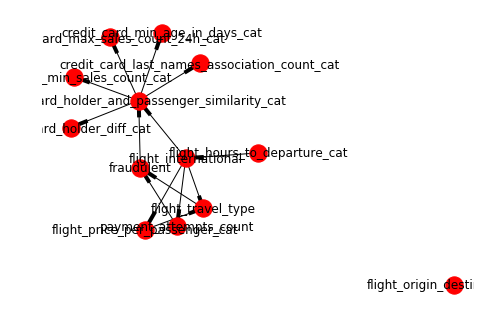

In [323]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show()

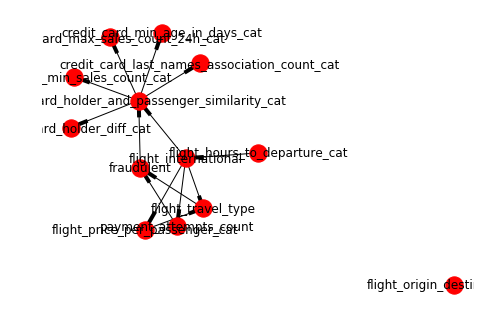

In [324]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show()

#### Parameter learning

In [325]:
# from pgmpy.estimators import ParameterEstimator
# pe = ParameterEstimator(best_model, data)

In [326]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(best_model, data)

In [327]:
best_model.fit(data, estimator=MaximumLikelihoodEstimator)

#### Queries

In [328]:
infer = VariableElimination(best_model)

In [329]:
print(
    infer.query(
        ['fraudulent']
    ) ['fraudulent']
)

╒══════════════╤═══════════════════╕
│ fraudulent   │   phi(fraudulent) │
╞══════════════╪═══════════════════╡
│ fraudulent_0 │            0.9728 │
├──────────────┼───────────────────┤
│ fraudulent_1 │            0.0272 │
╘══════════════╧═══════════════════╛


In [330]:
# Hours to departure: 0, 431.45
print(
    infer.query(
        ['fraudulent'],
        evidence={
            'flight_hours_to_departure_cat': 19
        }
    ) ['fraudulent']
)

╒══════════════╤═══════════════════╕
│ fraudulent   │   phi(fraudulent) │
╞══════════════╪═══════════════════╡
│ fraudulent_0 │            0.9704 │
├──────────────┼───────────────────┤
│ fraudulent_1 │            0.0296 │
╘══════════════╧═══════════════════╛


In [331]:
# Hours to departure 8197.55, 8629

print(
    infer.query(
        ['fraudulent'],
        evidence={
            'flight_hours_to_departure_cat': 17
        }
    ) ['fraudulent']
)

╒══════════════╤═══════════════════╕
│ fraudulent   │   phi(fraudulent) │
╞══════════════╪═══════════════════╡
│ fraudulent_0 │            0.9836 │
├──────────────┼───────────────────┤
│ fraudulent_1 │            0.0164 │
╘══════════════╧═══════════════════╛


In [334]:

print(
    infer.query(
        ['flight_hours_to_departure_cat'],
        evidence={
            'flight_international': 0
        }
    ) ['flight_hours_to_departure_cat']
)

╒══════════════════════════════════╤══════════════════════════════════════╕
│ flight_hours_to_departure_cat    │   phi(flight_hours_to_departure_cat) │
╞══════════════════════════════════╪══════════════════════════════════════╡
│ flight_hours_to_departure_cat_0  │                               0.0492 │
├──────────────────────────────────┼──────────────────────────────────────┤
│ flight_hours_to_departure_cat_1  │                               0.0352 │
├──────────────────────────────────┼──────────────────────────────────────┤
│ flight_hours_to_departure_cat_2  │                               0.0221 │
├──────────────────────────────────┼──────────────────────────────────────┤
│ flight_hours_to_departure_cat_3  │                               0.0133 │
├──────────────────────────────────┼──────────────────────────────────────┤
│ flight_hours_to_departure_cat_4  │                               0.0085 │
├──────────────────────────────────┼──────────────────────────────────────┤
│ flight_hou

In [335]:

print(
    infer.query(
        ['flight_hours_to_departure_cat'],
        evidence={
            'flight_international': 1
        }
    ) ['flight_hours_to_departure_cat']
)

╒══════════════════════════════════╤══════════════════════════════════════╕
│ flight_hours_to_departure_cat    │   phi(flight_hours_to_departure_cat) │
╞══════════════════════════════════╪══════════════════════════════════════╡
│ flight_hours_to_departure_cat_0  │                               0.1002 │
├──────────────────────────────────┼──────────────────────────────────────┤
│ flight_hours_to_departure_cat_1  │                               0.0881 │
├──────────────────────────────────┼──────────────────────────────────────┤
│ flight_hours_to_departure_cat_2  │                               0.0701 │
├──────────────────────────────────┼──────────────────────────────────────┤
│ flight_hours_to_departure_cat_3  │                               0.0397 │
├──────────────────────────────────┼──────────────────────────────────────┤
│ flight_hours_to_departure_cat_4  │                               0.0393 │
├──────────────────────────────────┼──────────────────────────────────────┤
│ flight_hou

In [341]:
dict_columns['flight_price_per_passenger_cat']

array(['(10033.472, 12040.166]', '(12040.166, 14046.86]',
       '(14046.86, 16053.555]', '(16053.555, 18060.249]',
       '(18060.249, 20066.943]', '(2006.694, 4013.389]',
       '(20066.943, 22073.638]', '(22073.638, 24080.332]',
       '(24080.332, 26087.0263]', '(26087.0263, 28093.721]',
       '(28093.721, 30100.415]', '(30100.415, 32107.109]',
       '(34113.804, 36120.498]', '(38127.192, 40133.887]',
       '(4013.389, 6020.083]', '(48160.664, 50167.358]',
       '(58194.136, 60200.83]', '(6020.083, 8026.777]',
       '(8026.777, 10033.472]', '[-60.201, 2006.694]'], dtype=object)

In [343]:
#0~2000
print(
    infer.query(
        ['fraudulent'],
        evidence={
            'flight_price_per_passenger_cat': 19
        }
    ) ['fraudulent']
)

╒══════════════╤═══════════════════╕
│ fraudulent   │   phi(fraudulent) │
╞══════════════╪═══════════════════╡
│ fraudulent_0 │            0.9692 │
├──────────────┼───────────────────┤
│ fraudulent_1 │            0.0308 │
╘══════════════╧═══════════════════╛


In [345]:
# 6000~8000
print(
    infer.query(
        ['fraudulent'],
        evidence={
            'flight_price_per_passenger_cat': 17
        }
    ) ['fraudulent']
)

╒══════════════╤═══════════════════╕
│ fraudulent   │   phi(fraudulent) │
╞══════════════╪═══════════════════╡
│ fraudulent_0 │            0.9844 │
├──────────────┼───────────────────┤
│ fraudulent_1 │            0.0156 │
╘══════════════╧═══════════════════╛


In [346]:
#0~2000
print(
    infer.query(
        ['flight_international'],
        evidence={
            'flight_price_per_passenger_cat': 19
        }
    ) ['flight_international']
)

╒════════════════════════╤═════════════════════════════╕
│ flight_international   │   phi(flight_international) │
╞════════════════════════╪═════════════════════════════╡
│ flight_international_0 │                      0.9197 │
├────────────────────────┼─────────────────────────────┤
│ flight_international_1 │                      0.0803 │
╘════════════════════════╧═════════════════════════════╛


In [347]:
#0~2000
print(
    infer.query(
        ['flight_international'],
        evidence={
            'flight_price_per_passenger_cat': 17
        }
    ) ['flight_international']
)

╒════════════════════════╤═════════════════════════════╕
│ flight_international   │   phi(flight_international) │
╞════════════════════════╪═════════════════════════════╡
│ flight_international_0 │                      0.0069 │
├────────────────────────┼─────────────────────────────┤
│ flight_international_1 │                      0.9931 │
╘════════════════════════╧═════════════════════════════╛


In [ ]:
print(
    infer.query(
        ['flight_international'],
        evidence={
            'flight_price_per_passenger_cat': 17
        }
    ) ['flight_international']
)